In [ ]:
import pandas as pd
import chardet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import numpy as np

# Dosyanın karakter kodlamasını belirleme
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        rawdata = f.read()
    result = chardet.detect(rawdata)
    return result['encoding']

# Dosyanın yolu
file_path = 'hp_script.csv'

# Karakter kodlamasını belirleyerek veriyi okuma
encoding = detect_encoding(file_path)
df = pd.read_csv(file_path, encoding=encoding)

# Karakter isimlerini sayısal değerlere dönüştürme
label_encoder = LabelEncoder()
df['character_encoded'] = label_encoder.fit_transform(df['character_name'])

# Metin verisini tokenleştirme
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['dialogue'])
sequences = tokenizer.texts_to_sequences(df['dialogue'])
word_index = tokenizer.word_index

# Pad sequences
max_seq_length = 100  # Daha kısa bir maksimum sekans uzunluğu belirleyin
X = pad_sequences(sequences, maxlen=max_seq_length)
y = df['character_encoded'].values

# Sınıf dengesini sağlamak için over-sampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

# Veriyi eğitim ve test setlerine bölmek
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model oluşturma
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_seq_length))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Modeli derleme
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Erken durdurma ve model kontrol kriteri belirleme
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])

# En iyi modeli yükleme
model.load_weights('best_model.h5')

# Modeli değerlendirme
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/50
118/118 [==============================] - 288s 2s/step - loss: 3.1708 - accuracy: 0.1303 - val_loss: 2.1193 - val_accuracy: 0.4396
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


118/118 [==============================] - 260s 2s/step - loss: 1.3897 - accuracy: 0.5860 - val_loss: 0.5969 - val_accuracy: 0.8351
Epoch 3/50
118/118 [==============================] - 261s 2s/step - loss: 0.5822 - accuracy: 0.8324 - val_loss: 0.3309 - val_accuracy: 0.9083
Epoch 4/50
118/118 [==============================] - 268s 2s/step - loss: 0.3605 - accuracy: 0.8922 - val_loss: 0.2755 - val_accuracy: 0.9221
Epoch 5/50
118/118 [==============================] - 268s 2s/step - loss: 0.2754 - accuracy: 0.9182 - val_loss: 0.2158 - val_accuracy: 0.9374
Epoch 6/50
118/118 [==============================] - 269s 2s/step - loss: 0.2107 - accuracy: 0.9331 - val_loss: 0.2100 - val_accuracy: 0.9433
Epoch 7/50
118/118 [==============================] - 260s 2s/step - loss: 0.1919 - accuracy: 0.9398 - val_loss: 0.1918 - val_accuracy: 0.9496
Epoch 8/50
118/118 [==============================] - 268s 2s/step - loss: 0.1603 - accuracy: 0.9482 - val_loss: 0.1895 - val_accuracy: 0.9502
Epoch 9/50

In [2]:
import pandas as pd
import chardet
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# nltk durma kelimelerini indir
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Dosyanın karakter kodlamasını belirleme
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        rawdata = f.read()
    result = chardet.detect(rawdata)
    return result['encoding']

# Durma kelimelerini silme
def remove_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(tokens)

# Ortak karakterleri bulma
def find_common_characters(df1, df2):
    common_characters = set(df1['character_name']).intersection(set(df2['character_name']))
    return common_characters

# Dosyanın yolu
train_file_path = 'hp_script.csv'
test_file_path = 'hp_script2.csv'

# Karakter kodlamasını belirleyerek veriyi okuma
train_encoding = detect_encoding(train_file_path)
test_encoding = detect_encoding(test_file_path)
df_train = pd.read_csv(train_file_path, encoding=train_encoding)
df_test = pd.read_csv(test_file_path, encoding=test_encoding)

# Ortak karakterleri bulma
common_characters = find_common_characters(df_train, df_test)

# Ortak karakterlerin olduğu satırları filtreleme
df_train_common = df_train[df_train['character_name'].isin(common_characters)]
df_test_common = df_test[df_test['character_name'].isin(common_characters)]

# Durma kelimelerini silme
df_train_common['dialogue'] = df_train_common['dialogue'].apply(remove_stopwords)
df_test_common['dialogue'] = df_test_common['dialogue'].apply(remove_stopwords)

# Karakter isimlerini sayısal değerlere dönüştürme
label_encoder = LabelEncoder()
df_train_common['character_encoded'] = label_encoder.fit_transform(df_train_common['character_name'])
df_test_common['character_encoded'] = label_encoder.transform(df_test_common['character_name'])

# Metin verisini tokenleştirme
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train_common['dialogue'])
sequences_train = tokenizer.texts_to_sequences(df_train_common['dialogue'])
sequences_test = tokenizer.texts_to_sequences(df_test_common['dialogue'])
word_index = tokenizer.word_index

# Pad sequences
max_seq_length = 100
X_train = pad_sequences(sequences_train, maxlen=max_seq_length)
X_test = pad_sequences(sequences_test, maxlen=max_seq_length)
y_train = df_train_common['character_encoded'].values
y_test = df_test_common['character_encoded'].values

# Model oluşturma
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_seq_length))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Modeli derleme
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Erken durdurma ve model kontrol kriteri belirleme
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# En iyi modeli yükleme
model.load_weights('best_model.h5')

# Modeli test etme
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-2-d8852408eecc>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_common['dialogue'] = df_train_common['dialogue'].apply(remove_stopwords)
<ipython-input-2-d8852408eecc>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_common['dialogue'] = df_test_common['dialogue'].apply(remove_stopwords)
<ipython-input-2-d8852408eecc>:61: SettingWithCopyWarning: 
A value is trying

Epoch 1/50
10/10 [==============================] - 51s 3s/step - loss: 3.0057 - accuracy: 0.2538 - val_loss: 2.1885 - val_accuracy: 0.3851
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 21s 2s/step - loss: 2.5599 - accuracy: 0.2030 - val_loss: 2.0553 - val_accuracy: 0.3851
Epoch 3/50
10/10 [==============================] - 23s 2s/step - loss: 2.4986 - accuracy: 0.2707 - val_loss: 2.1267 - val_accuracy: 0.3851
Epoch 4/50
10/10 [==============================] - 22s 2s/step - loss: 2.4457 - accuracy: 0.2724 - val_loss: 2.0768 - val_accuracy: 0.3851
Epoch 5/50
10/10 [==============================] - 22s 2s/step - loss: 2.4169 - accuracy: 0.2961 - val_loss: 2.0271 - val_accuracy: 0.3851
Epoch 6/50
10/10 [==============================] - 23s 2s/step - loss: 2.3408 - accuracy: 0.2860 - val_loss: 2.0492 - val_accuracy: 0.3784
Epoch 7/50
10/10 [==============================] - 21s 2s/step - loss: 2.2565 - accuracy: 0.3587 - val_loss: 2.0647 - val_accuracy: 0.3784
Epoch 8/50
10/10 [==============================] - 22s 2s/step - loss: 2.1487 - accuracy: 0.3672 - val_loss: 2.1067 - val_accuracy: 0.3716
Epoch 9/50
10/10 [=============

In [4]:
import numpy as np

# Metni işleme ve tahmin yapma fonksiyonu
def predict_character(dialogue, model, tokenizer, label_encoder, max_seq_length):
    # Metni tokenleştirme ve pad sequence
    sequence = tokenizer.texts_to_sequences([dialogue])
    padded_sequence = pad_sequences(sequence, maxlen=max_seq_length)

    # Tahmin yapma
    prediction = model.predict(padded_sequence)
    predicted_class = np.argmax(prediction, axis=1)

    # Tahmini karakter adı olarak dönüştürme
    predicted_character = label_encoder.inverse_transform(predicted_class)
    return predicted_character[0]

# Örnek bir diyalog
example_dialogue = "No problems, I trust, Hagrid?"

# Karakter tahmini yapma
predicted_character = predict_character(example_dialogue, model, tokenizer, label_encoder, max_seq_length)
print(f"The predicted character for the dialogue '{example_dialogue}' is: {predicted_character}")


1/1 [==============================] - 1s 1s/step
The predicted character for the dialogue 'No problems, I trust, Hagrid?' is: Harry Potter


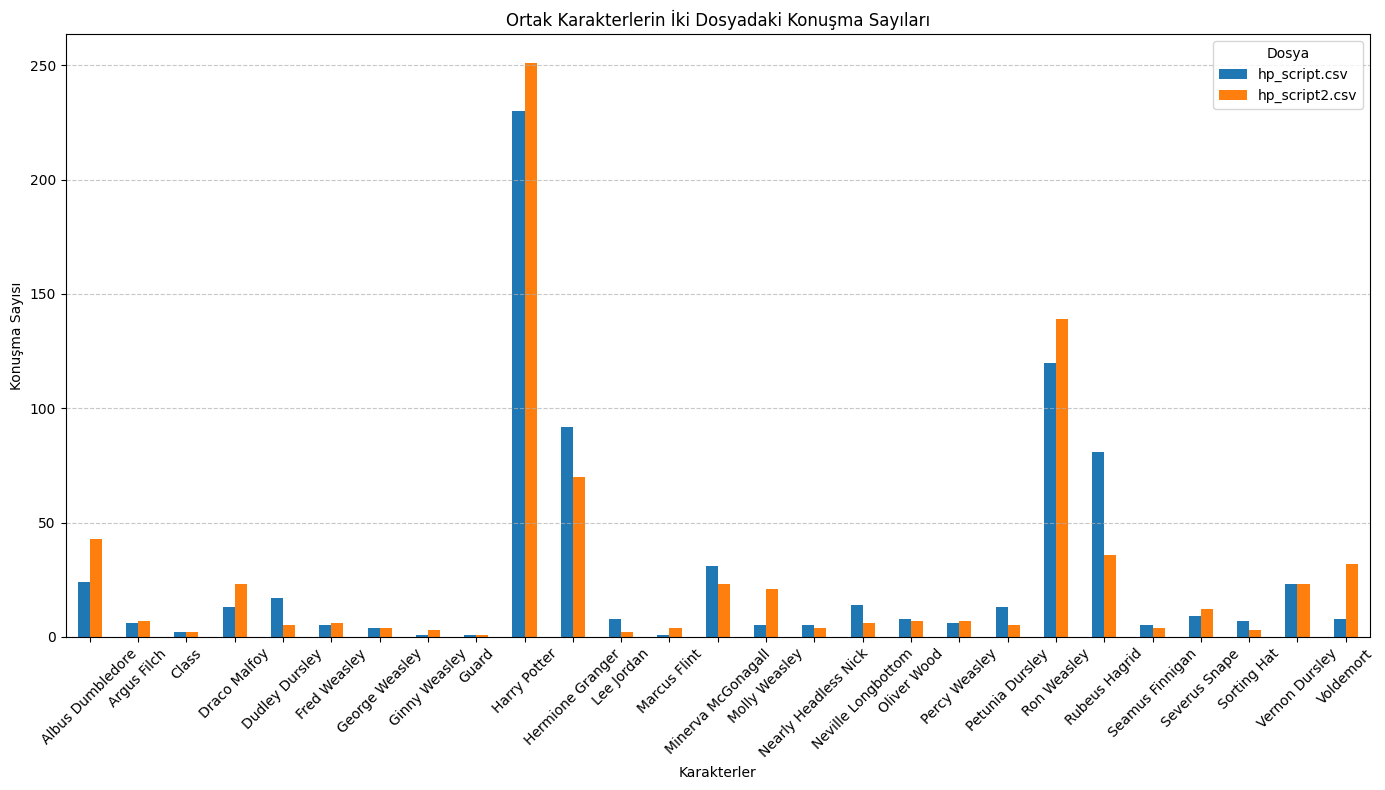

In [9]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt

# Dosyanın karakter kodlamasını belirleme
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        rawdata = f.read()
    result = chardet.detect(rawdata)
    return result['encoding']

# İlk datasetin karakter kodlamasını belirleme ve yükleme
file_path1 = 'hp_script.csv'
encoding1 = detect_encoding(file_path1)
df1 = pd.read_csv(file_path1, encoding=encoding1)

# İkinci datasetin karakter kodlamasını belirleme ve yükleme
file_path2 = 'hp_script2.csv'
encoding2 = detect_encoding(file_path2)
df2 = pd.read_csv(file_path2, encoding=encoding2)

# Her iki dosyadaki karakter isimlerini elde etme
unique_characters_df1 = set(df1['character_name'])
unique_characters_df2 = set(df2['character_name'])

# Ortak karakterleri bulma
common_characters = unique_characters_df1.intersection(unique_characters_df2)

# Ortak karakterlere sahip satırları filtreleme
df1_filtered = df1[df1['character_name'].isin(common_characters)]
df2_filtered = df2[df2['character_name'].isin(common_characters)]

# Ortak karakterlerin konuşma sayılarını hesaplama
df1_counts = df1_filtered['character_name'].value_counts().sort_index()
df2_counts = df2_filtered['character_name'].value_counts().sort_index()

# DataFrame oluşturma
counts_df = pd.DataFrame({
    'hp_script.csv': df1_counts,
    'hp_script2.csv': df2_counts
})

# Bar grafiği oluşturma
counts_df.plot(kind='bar', figsize=(14, 8))
plt.title('Ortak Karakterlerin İki Dosyadaki Konuşma Sayıları')
plt.xlabel('Karakterler')
plt.ylabel('Konuşma Sayısı')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dosya')
plt.tight_layout()
plt.show()
